In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

%matplotlib inline

In [2]:
# Import Model building package
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
# Supervised
from sklearn.linear_model import LogisticRegression  # for Logistic Regression algorithm
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.ensemble import RandomForestClassifier 
# Unsupervised
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
# Evaluate model performace
from sklearn import metrics #for checking the model accuracy


# Load data

In [3]:
data = pd.read_csv("../data/Identifying Fraudulent Activities/Fraud/Fraud_Data.csv")
ip2country = pd.read_csv("../data/Identifying Fraudulent Activities/Fraud/IpAddress_to_Country.csv")

In [4]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [5]:
ip2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [6]:
map_country = ip2country.loc[1,:]

# Explotary data analysis

In [7]:
grouped = data.groupby('class', as_index = False).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'user_cnt'})
grouped['percentage'] = (grouped['user_cnt'] / grouped['user_cnt'].sum()) * 100
grouped

,class,user_cnt,percentage
0,0,136961,90.635423
1,1,14151,9.364577


- Fraud ratio: count and percentage

<AxesSubplot:xlabel='class', ylabel='count'>

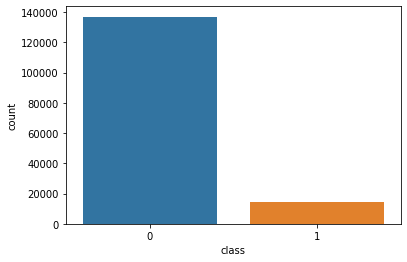

In [8]:
sns.countplot(x='class', data = data)

<AxesSubplot:xlabel='class', ylabel='percentage'>

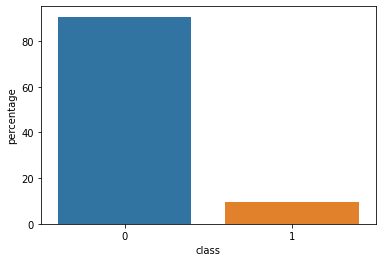

In [9]:
sns.barplot(x="class", y="percentage", data=grouped)

- Source Direct has lowest volume but highest fraud rate

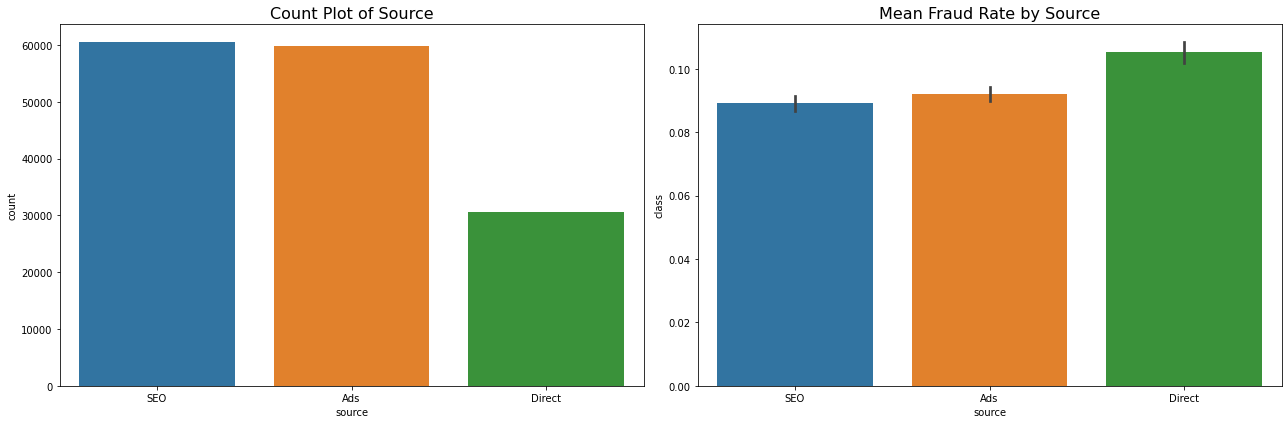

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Source', fontsize=16)

sns.barplot(x='source', y ='class', data = data, ax=ax[1])
ax[1].set_title('Mean Fraud Rate by Source', fontsize=16)
plt.tight_layout()
plt.show()

- IE has the lowest (but not significnat) fraud rate

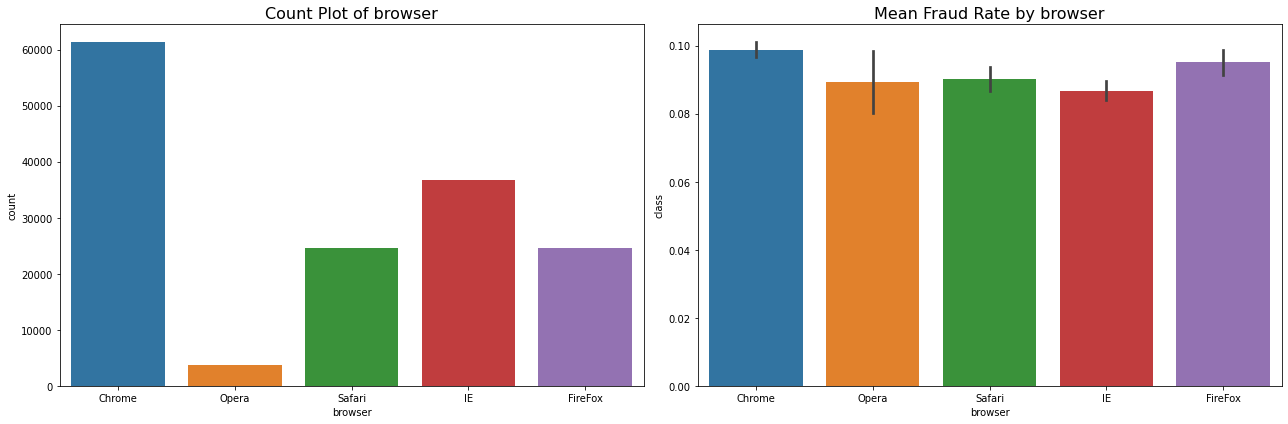

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser', data=data, ax=ax[0])
ax[0].set_title('Count Plot of browser', fontsize=16)

sns.barplot(x='browser', y ='class', data = data, ax=ax[1])
ax[1].set_title('Mean Fraud Rate by browser', fontsize=16)
plt.tight_layout()
plt.show()

- Female has lower volume but fraud rate is pretty much the same

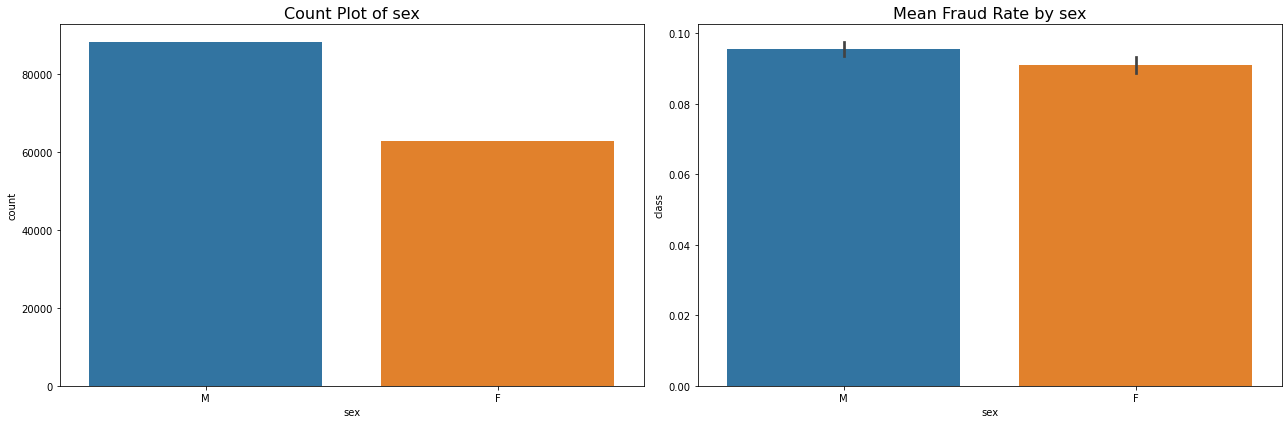

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='sex', data=data, ax=ax[0])
ax[0].set_title('Count Plot of sex', fontsize=16)

sns.barplot(x='sex', y ='class', data = data, ax=ax[1])
ax[1].set_title('Mean Fraud Rate by sex', fontsize=16)
plt.tight_layout()
plt.show()

- Age distribution is right skewed
- Fraud rate is higher with higher age

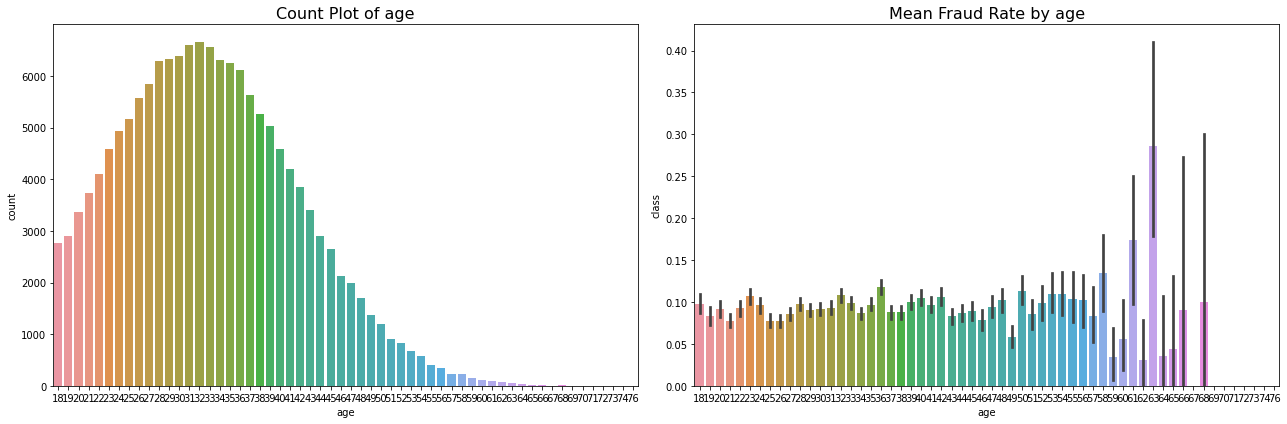

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='age', data=data, ax=ax[0])
ax[0].set_title('Count Plot of age', fontsize=16)

sns.barplot(x='age', y ='class', data = data, ax=ax[1])
ax[1].set_title('Mean Fraud Rate by age', fontsize=16)
plt.tight_layout()
plt.show()

- Purchase value is right skew
- High purchase value has higher fraud rate

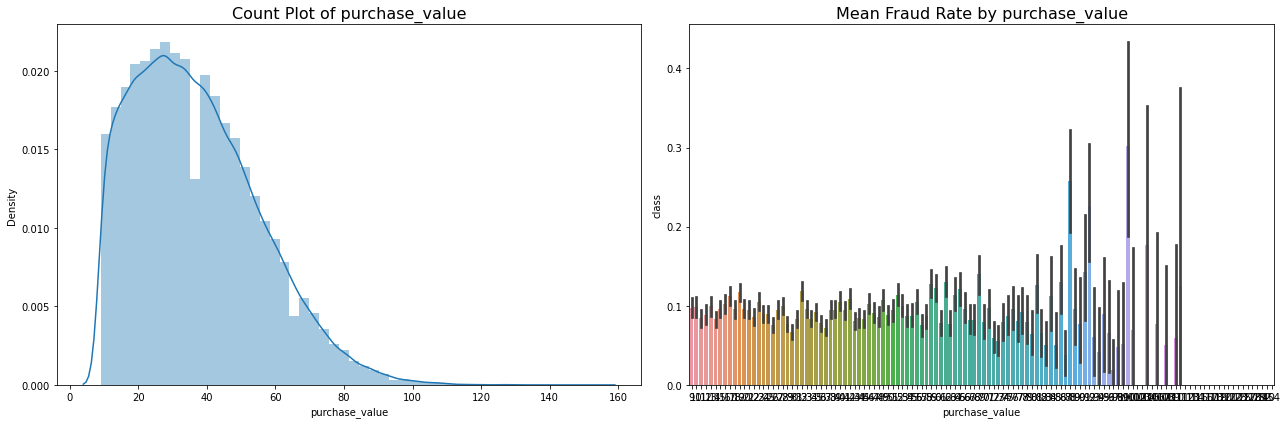

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data['purchase_value'], ax=ax[0])
ax[0].set_title('Count Plot of purchase_value', fontsize=16)

sns.barplot(x='purchase_value', y ='class', data = data, ax=ax[1])
ax[1].set_title('Mean Fraud Rate by purchase_value', fontsize=16)
plt.tight_layout()
plt.show()

# Merge two dataset 

In [15]:
countries = []

for i in range(len(data)):
    map_country = ip2country[(data.loc[i, 'ip_address'] >= ip2country.lower_bound_ip_address) & (data.loc[i, 'ip_address'] <= ip2country.upper_bound_ip_address)]
    if len(map_country) == 1:
        countries.append(map_country['country'].values[0])
    else:
        countries.append('NA')
        
data['country'] = countries

In [16]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


# Feature Engineering
- Time difference between sign-up time and purchase time
- If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)
- Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts
- Usual week of the year and day of the week from time variables


In [17]:
data['purchase_time'] = pd.to_datetime(data['purchase_time'])
data['signup_time'] = pd.to_datetime(data['signup_time'])
time_diff = data['purchase_time'] - data['signup_time']
data['time_diff'] = time_diff.dt.seconds

In [18]:
group = data.groupby('device_id', as_index = False).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'num_device'})
data = data.merge(group, on = 'device_id', how = 'left')

In [19]:
group = data.groupby('ip_address', as_index = False).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'num_ip'})
data = data.merge(group, on = 'ip_address', how = 'left')

In [20]:
# Signup day and week
data['signup_day'] = data['signup_time'].dt.dayofweek
data['signup_week'] = data['signup_time'].dt.week

# Purchase day and week
data['purchase_day'] = data['purchase_time'].dt.dayofweek
data['purchase_week'] = data['purchase_time'].dt.week

# Model Building

In [21]:
data = pd.get_dummies(data, columns = ['source', 'browser', 'sex', 'country', 'signup_day', 'signup_week', 'purchase_day', 'purchase_week'], drop_first=True)

In [22]:
feature_list = data.columns.drop([u'user_id', u'signup_time', u'purchase_time', u'device_id', u'ip_address', u'class'])

In [23]:
# train, test = train_test_split(df, test_size = 0.3)
X = data[feature_list]# taking the training data features
Y = data['class']# output of our training data
train_X, test_x, train_y, test_y = train_test_split(X, Y ,test_size=0.2)

## Logistic Regression

In [25]:
# Logistic 
model = LogisticRegression()
model.fit(train_X,train_y)
prediction=model.predict(test_x)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(test_y, prediction))
print('The roc score of the Logistic Regression is', metrics.roc_auc_score(test_y, prediction))
print('The precision score of the Logistic Regression is', metrics.precision_score(test_y, prediction))
print('The recall score of the Logistic Regression is', metrics.recall_score(test_y, prediction))

The accuracy of the Logistic Regression is 0.950468186480495
The roc score of the Logistic Regression is 0.7545164999535896
The precision score of the Logistic Regression is 0.9193138500635324
The recall score of the Logistic Regression is 0.513667021654242


In [26]:
# and the rows will show the actual number of instances for each label.
print(metrics.confusion_matrix(test_y, prediction))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(test_y, prediction))

[[27279   127]
 [ 1370  1447]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27406
           1       0.92      0.51      0.66      2817

    accuracy                           0.95     30223
   macro avg       0.94      0.75      0.82     30223
weighted avg       0.95      0.95      0.94     30223



## Random Forest

In [27]:
# Random Forest
model = RandomForestClassifier()
model.fit(train_X,train_y)
prediction=model.predict(test_x)
print('The accuracy of the RF is',metrics.accuracy_score(test_y, prediction))
print('The roc score of the RF is', metrics.roc_auc_score(test_y, prediction))
print('The precision score of the RF is', metrics.precision_score(test_y, prediction))
print('The recall score of the RF is', metrics.recall_score(test_y, prediction))

The accuracy of the RF is 0.9558283426529465
The roc score of the RF is 0.7632050430048419
The precision score of the RF is 0.9993261455525606
The recall score of the RF is 0.5264465743698971


In [28]:
# the rows will show the actual number of instances for each label.
print(metrics.confusion_matrix(test_y, prediction))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(test_y, prediction))

[[27405     1]
 [ 1334  1483]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27406
           1       1.00      0.53      0.69      2817

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223



time_diff  | 0.21658
num_ip     | 0.14231
num_device | 0.13289
purchase_week_2 | 0.05258
purchase_value | 0.04778
age        | 0.04440
signup_week_2 | 0.03141
sex_M      | 0.01124
browser_IE | 0.00857
country_United States | 0.00804


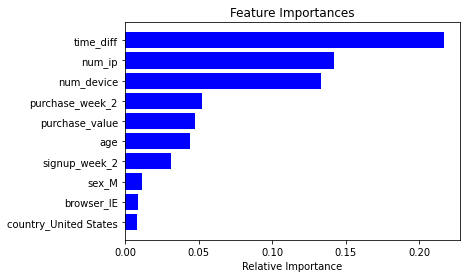

In [29]:
# Feature importance
importance = sorted(zip(feature_list, model.feature_importances_), key=lambda x:x[1], reverse=True)
for feature, val in importance[:10]:
    print('{0:10s} | {1:.5f}'.format(feature, val))
    
plt.title('Feature Importances')
plt.barh(range(len(importance[:10])), [val for feature, val in importance[:10]][::-1], color='b', align='center')
plt.yticks(range(len(importance[:10])), [feature for feature, val in importance[:10]][::-1])
plt.xlabel('Relative Importance')
plt.show()

## XGBoost

In [30]:
import xgboost as xgboost
model = xgboost.XGBClassifier(max_depth = 2, silent  = 1, objective = 'binary:logistic')
model.fit(train_X,train_y)
prediction = model.predict_proba(test_x)[:, 1]
prediction = prediction.round()

print('The accuracy of the RF is',metrics.accuracy_score(test_y, prediction))
print('The roc score of the RF is', metrics.roc_auc_score(test_y, prediction))
print('The precision score of the RF is', metrics.precision_score(test_y, prediction))
print('The recall score of the RF is', metrics.recall_score(test_y, prediction))

[23:38:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:38:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The accuracy of the RF is 0.9558283426529465
The roc score of the RF is 0.7632050430048419
The precision score of the RF is 0.9993261455525606
The recall score of the RF is 0.5264465743698971


In [31]:
# and the rows will show the actual number of instances for each label.
print(metrics.confusion_matrix(test_y, prediction.round()))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(test_y, prediction.round()))

[[27405     1]
 [ 1334  1483]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27406
           1       1.00      0.53      0.69      2817

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

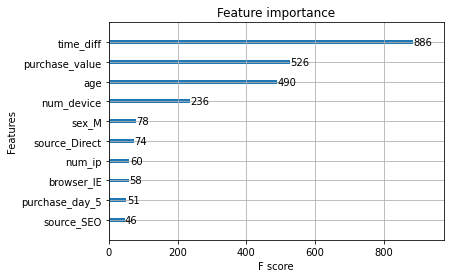

In [36]:
xgb.plot_importance(model, max_num_features=10)

## XGBoost Upsampling

In [37]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, Y)
# Train xgboost on smoted dataset
train_X_smote, test_X_smote, train_y_smote, test_y_smote = train_test_split(X_res, y_res, test_size = 0.3, random_state = 42)
XGBmodel_smote = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7, scale_pos_weight = 12, eval_metric = 'logloss')
XGBmodel_smote.fit(train_X_smote,train_y_smote)

## Predcit on the original dataset using the smote-xgboost model
prediction = XGBmodel_smote.predict(test_x)

print('The accuracy of the XGBoost Classifier with SMOTE is', metrics.accuracy_score(test_y, prediction))
print('The roc score of the XGBoost Classifier with SMOTE is', metrics.roc_auc_score(test_y, prediction))
print('The precision score of XGBoost Classifier with SMOTE is', metrics.precision_score(test_y, prediction))
print('The recall score of the XGBoost Classifier with SMOTE is', metrics.recall_score(test_y, prediction))
print('The f1 score of the XGBoost Classifier with SMOTE is', metrics.f1_score(test_y, prediction))


The accuracy of the XGBoost Classifier with SMOTE is 0.695132845845879
The roc score of the XGBoost Classifier with SMOTE is 0.7511585734395669
The precision score of XGBoost Classifier with SMOTE is 0.20967595534174457
The recall score of the XGBoost Classifier with SMOTE is 0.820021299254526
The f1 score of the XGBoost Classifier with SMOTE is 0.33395980916582335


# Compare models

[00:34:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




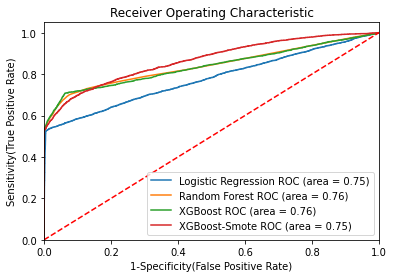

In [40]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(),
},
{
    'label': 'XGBoost',
    'model': xgboost.XGBClassifier(max_depth = 2, silent  = 1, objective = 'binary:logistic', eval_metric = 'logloss'),
},
{
    'label': 'XGBoost-Smote',
    'model': xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7, scale_pos_weight = 12, eval_metric = 'logloss'),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    if m['label'] != 'XGBoost-Smote':
        model.fit(train_X,train_y) # train the model
        y_pred=model.predict(test_x) # predict the test data
    else:
        model = XGBmodel_smote
        y_pred=XGBmodel_smote.predict(test_x)                           
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(test_y, model.predict_proba(test_x)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(test_y, model.predict(test_x))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display